# Conformal Predictions for ML Models (Dupont)

This is a notebook dedicated to the python implementation of the conformal prediction framework for ml models.

**Index**
* [Library Imports](#library_imports)
* [Enviroments & Models Function](#environment_models) 
* [Data Split Function](#data_split)
* [NonConformist Class](#nonconformal_class)
* [Loading Model and Environments](#Loading_Model)
* [Data Setup](#data_setup)
* [Training and Calibration Procedure](#training_calibration)
* [Efficiency and Validity](#efficiency_validity)


<a id='library_imports'></a>
## Library Imports

Import necessary modules for notebook

In [1]:
import dotenv
import prolerep.analysis.utils as utils
import mlflow.pyfunc
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist

import scipy
import math
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

<a id='environment_models'></a>
## Load Environment and Models Function
* Function comitted to preparing the environment variables and model to be used

In [2]:
def load_model():
    dotenv.load_dotenv(".env")
    runs = mlflow.search_runs(4) #ExperimentID:(4:Expression,13:Activity,14:Stability)
    cols = ["run_id", "params.model_name", "metrics.valid_r_square",
        "metrics.train_r_square", "params.prepared_dataset_uri"]
    best = (
    runs
    .sort_values("metrics.valid_r_square", ascending=False)
    .groupby("params.model_name")
    .head(n=1)
    [cols]
    .set_index("params.model_name"))    
    PLS_Model = mlflow.pyfunc.load_model(f"runs:/{best.loc['PLSRun'].run_id}/logged_model")
    OneHot_Model = mlflow.pyfunc.load_model(f"runs:/{best.loc['OneHotRun'].run_id}/logged_model")
    #Einsum_Model = mlflow.pyfunc.load_model(f"runs:/{best.loc['EinsumRun'].run_id}/logged_model")
    return PLS_Model, OneHot_Model

In [7]:
best

,run_id,metrics.valid_r_square,metrics.train_r_square,params.prepared_dataset_uri
params.model_name,,,,
OneHotRun,fee471beeffc44f4a909c2063b566763,0.611543,0.705636,s3://mlflow/4/1a163dd9fecc435fbf340dbdd5170cb9...
EinsumRun,29a5d0b58bb04294b986474b71c8ab65,0.584355,0.570828,s3://mlflow/4/29a5d0b58bb04294b986474b71c8ab65...
PLSRun,f4c6fc69bcc84d1fa7fa94c6c38f0652,0.484468,0.591680,s3://mlflow/4/1a163dd9fecc435fbf340dbdd5170cb9...


<a id='data_split'></a>
## Data Split Function
* Function dedicated to splitting original dataset

In [3]:
def data_split(df):
    train = df.loc[df['split'] == 'train']
    valid = df.loc[df['split'] == 'valid']
    valid = valid.drop('split', 1)
    train = train.drop('split', 1)
    X_test = valid.iloc[:,:-1]
    y_test = valid.iloc[:,-1] 
    X_train = train.iloc[:,:-1] 
    y_train = train.iloc[:,-1] 
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size =0.2)
    print("Data has been split")
    print("X_train and y_train shape: "+ str(X_train.shape) + str(y_train.shape))
    print("X_cal and y_cal shape: "+ str(X_cal.shape) + str(y_cal.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   X_train.shape[1],
                                                   np.unique(y_train).size))
    return X_test, y_test, X_train, y_train, X_cal, y_cal


In [96]:
def obtain_residuals(predictions, true_labels):
    '''
    Calculates absolute error nonconformity scores for calibration set.
    For each correct output in ``y``, nonconformity is defined as
    math::
    | y_i (predicted labels) - y^_i (true labels) |     
       
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
        
    Returns:
    Calibration scores: numpy array of shape [n_samples]
    Non-conformity scores of the samples
    '''
               
    true_labels = np.array(y_cal)
    predictions = predictions.flatten()
        
    #residuals = np.abs(predictions - true_labels)
    residuals = np.abs(predictions-true_labels)
    #residuals = np.sort(residuals)[::-1] #sort in descending order
    print("Original Residuals Calculated")
        
    return residuals

In [97]:
def calculate_borders(updated_residuals, significance):
    ''' 
    Function applies the partial inverse of the nonconformity function
    to calculate the prediction intervals where:
               
    @params
    calibration_scores: Nonconformity scores obtained from the conformal predictor [n_calibration_samples]
    Significance: Float value between 0-1 (i.e. 0.05)
        
    Returns:
        
    Interval: Numpy array of shape [n_samples, 2] that determines
    the min and max interval boundaries for each prediction
    '''
        
    border = int(np.floor(significance * (updated_residuals.size + 1))) - 1
    border = min(max(border, 0), updated_residuals.size - 1)
        
    return np.vstack([updated_residuals[border], updated_residuals[border]])

In [98]:
def conformal_predictions(model1, X_test, updated_residuals, significance):
    """
    Function will construct the prediction intervals 
    for a set of test examples. 
        
    This applies the partial inverse nonconformity function
    to each prediction from the underlying model, thus
    resulting in a prediction interval for each test pattern.

    @params
    ----------
    X_test: Numpy array of shape [n_samples, n_features]
    Inputs of test patterns for which to predict final output values

    Significance: Considered a float between 0 and 1; determimned as 
    the maximum allowed error rate of predictions.
    
    Returns
    -------
    p : numpy array of shape [n_samples, 2] or [n_samples, 2, 99]
    When significance value is a float between 0 and 1, then p 
    contains the prediction intervals (minimum and maximum boundaries)
    for the set of test patterns at the chosen significance level.
    """
    n_test = X_test.shape[0] #Takes shape of X_test row number
    norm = np.ones(n_test) #Returns an array of X_test shape, filled with ones.
    test_predictions = model1.predict(X_test) #Predictions from test data
    test_predictions = test_predictions.flatten() #Returns a collapsed array as 1D

    if significance:
        intervals = np.zeros((X_test.shape[0], 2)) #Creates empty 2D numpy array for saving prediction intervals
        err_dist = calculate_borders(updated_residuals, significance) #Applies inverse of nonconformity scores
        err_dist = np.hstack([err_dist] * n_test) ##Stack arrays in sequence horizontally (column wise)
        err_dist *= norm

        intervals[:, 0] = test_predictions - err_dist[0, :] #[0] creates lower boundary of the prediction interval
        intervals[:, 1] = test_predictions + err_dist[1, :] #[1] creates upper boundary of the prediction interval
        
        print("Prediction Intervals Created")

        return intervals

In [99]:
#########################
## Efficiency Measures ##
#########################
def prediction_size(predictions):
    """
    Calculates the general and average prediction interval size 
    based on a conformal prediction regression model.
    
    @params
    prediction_intervals: Prediction Intervals determined from the test patterns
    
    returns:
    
    Interval Size: Array that contains the size of the predicted intervals
    """
    interval_size = predictions[:, 1] - predictions[:, 0] #Efficiency measure
    mean_size = np.mean(interval_size)
        
    return interval_size, mean_size    

In [100]:
 def evaluation_table(predictions, size, y):
    '''
    Gives a final table that contains the prediction intervals, their size
    and original (true) labels of the test patterns. 
    Allows to determine efficiency of predictions
    
    @params
    predictions: Prediction intervals determined from the test patterns
    size: Size of the respective prediction intervals
    y: array of the true labels (i.e. y_test)
        
    returns:
        
    Tabulated results for the evaluation function
    ''' 
    header = ['Min','Max','Original Label','Interval Size']
    table = np.vstack([predictions.T, y, size.T]).T
    predictions_table = pd.DataFrame(table, columns = header)

    return predictions_table

### Running Functions

#### Loading Environments and Model
<a id='Loading_Model'></a>

In [101]:
PLS_Model,OneHot_Model = load_model() #Load underying ML Models

/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PLSRegression from version 0.22.2.post1 when using version 0.23.1. This might lead

In [102]:
#Make Copies of Original Model
PLS_Model1 = PLS_Model #Used to predict original target: Expression
PLS_Model2 = PLS_Model #Used to predict new target: Residuals

In [103]:
df = utils.read_csv_from_s3("s3://mlflow/4/1a163dd9fecc435fbf340dbdd5170cb9/artifacts/dataset.csv") #Upload dataset from MLFlow
#Divide training data into two subsets (proper training and calibration data)
X_test, y_test, X_train, y_train, X_cal, y_cal = data_split(df)
df.head() #Original Dataset

Data has been split
X_train and y_train shape: (11694, 2)(11694,)
X_cal and y_cal shape: (2924, 2)(2924,)
11694 instances, 2 features, 10537 classes


,new_host,split,sequence,expression
0,False,train,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.039268
1,False,train,--ASVPYGVSQIKAPALH-SQGYTGSNVKVAVIDSGIDSSHPDLKV...,0.039268
2,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.261457
3,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.265189
4,False,train,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,0.419681


#### Training and Calibration Procedure
* Train the underlying model
* Obtain initial predictions and residuals
<a id='training_calibration'></a>


In [104]:
PLS_Model1.fit(X_train, y_train) #Train model over proper training set
print("M1 has been fitted")

M1 has been fitted


In [105]:
calibration_predictions = PLS_Model1.predict(X_cal)
print("Calibation predictions have been established")

Calibation predictions have been established


In [106]:
#Calculate Residuals
original_residuals = obtain_residuals(calibration_predictions, y_cal)

Original Residuals Calculated


In [107]:
#Convert original residuals to pandas dataframe column
residuals_df = pd.DataFrame()
residuals_df['residuals']=pd.Series(original_residuals)

In [108]:
#Fit M2 to X_cal data with residuals
PLS_Model2.fit(X_cal, residuals_df)
print("M2 has been fitted")

M2 has been fitted


In [109]:
calibration2_predictions = PLS_Model2.predict(X_cal)

In [110]:
updated_residuals = obtain_residuals(calibration2_predictions, y_cal)

Original Residuals Calculated


In [111]:
prediction_intervals = conformal_predictions(PLS_Model1, X_test, updated_residuals, significance = 0.05)

Prediction Intervals Created


In [112]:
interval_size, mean_size = prediction_size(prediction_intervals)

In [113]:
predictions_table = evaluation_table(prediction_intervals, interval_size, y_test)

In [114]:
predictions_table

,Min,Max,Original Label,Interval Size
0,-0.393848,0.425729,0.039268,0.819577
1,-0.349199,0.470378,0.039268,0.819577
2,-0.359239,0.460339,0.335382,0.819577
3,-0.414342,0.405236,0.144229,0.819577
4,-0.423666,0.395911,0.146150,0.819577
...,...,...,...,...
3598,-0.400038,0.419539,0.422425,0.819577
3599,-0.358132,0.461446,0.102519,0.819577
3600,-0.361857,0.457721,0.079030,0.819577
3601,-0.308871,0.510707,0.923660,0.819577


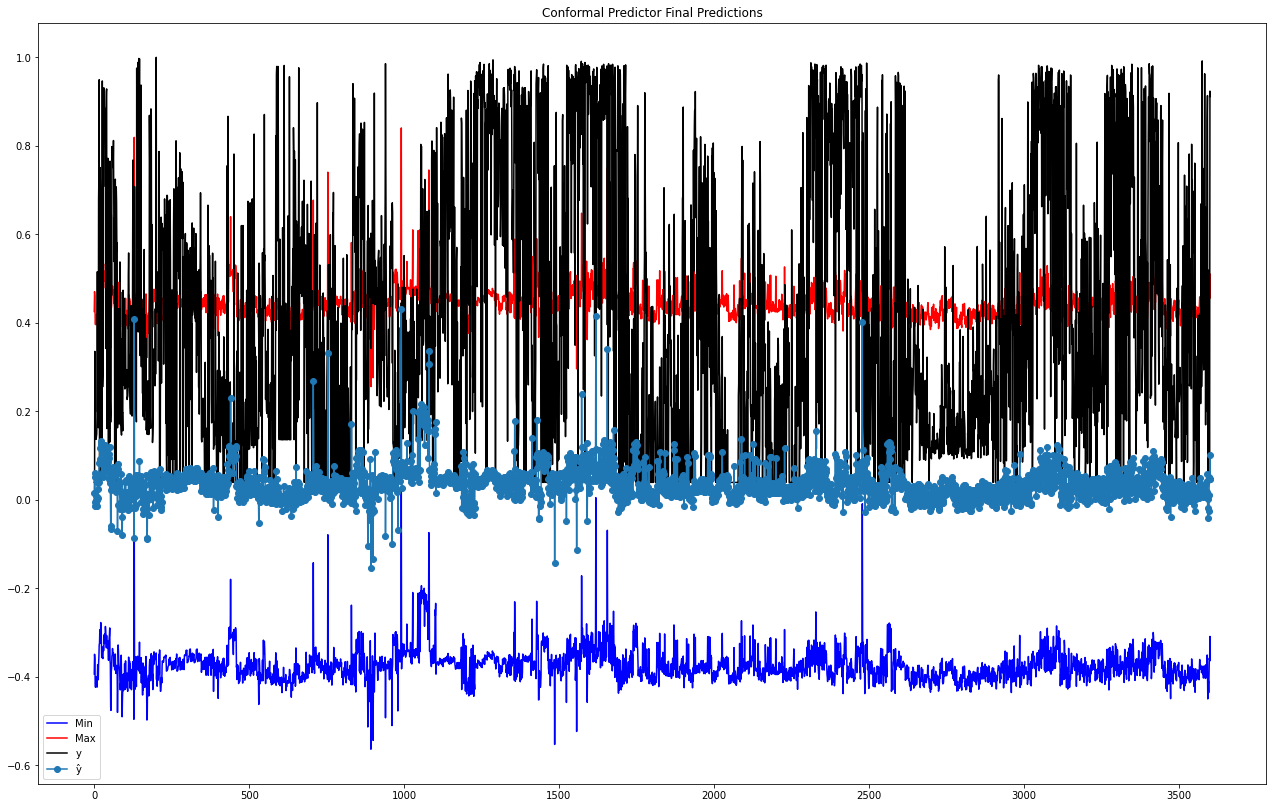

In [115]:
fig = plt.figure(1, figsize = (22,14)) # Figure size in inches (size_x, size_y)
ax = plt.axes()
min_val = prediction_intervals[:, 0]
max_val = prediction_intervals[:, 1]
true_values = y_test.to_numpy()
predicted_values = PLS_Model1.predict(X_test) #Predictions from test data (run at least once for the plot to work)
plt.plot(min_val, label = "Min", color='blue')
plt.plot(max_val, label = "Max", color='red')
plt.plot(true_values, label = "y", color = "black")
plt.plot(predicted_values, label = "y\u0302", marker='o')
plt.title('Conformal Predictor Final Predictions')
plt.legend()
plt.show()